# generate data with and without warping 

In [27]:
%load_ext autoreload
%autoreload 2
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

from sim_with_warp import generate_clustered_survival_data_warp,generate_clustered_survival_data
from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest


np.random.seed(42)
torch.manual_seed(42)
data_warp = generate_clustered_survival_data_warp(N=10000, D=20, T=50, K=5, P=1, beta_warp_sd=0.2, warping=True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data_warp['rho'].max()

np.float64(2.40573335314328)

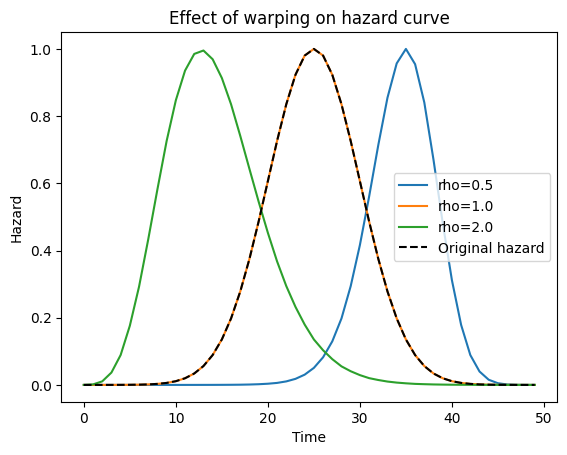

In [7]:

T = 50
t = np.arange(T)
T1 = T-1
phi = np.exp(-0.5 * ((t-25)/5)**2)  # Example bell-shaped hazard

for rho in [0.5, 1.0, 2.0]:
    t_warped = ((t / T1) ** (1.0 / rho)) * T1
    hazard_warped = np.interp(t_warped, t, phi)
    plt.plot(t, hazard_warped, label=f"rho={rho}")

plt.plot(t, phi, 'k--', label="Original hazard")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Hazard")
plt.title("Effect of warping on hazard curve")
plt.show()

In [8]:
import pickle
with open("sim_warp.pkl", "wb") as f:
    pickle.dump(data_warp, f)

# we can visualize what the mean simulated rho was 

Let's also look at som efoolks with early onset disease and visualize their trajectories

In [9]:
pi = data_warp['pi']  # [N, D, T]


In [10]:
pi.shape

(10000, 20, 50)

In [13]:

import numpy as np
import matplotlib.pyplot as plt

d = 0  # Choose a disease index to analyze

# Find onset time for each individual (first time pi > threshold)
threshold = 0.0001
onset_times = (pi[:, d, :] > threshold).argmax(axis=1)
valid = (pi[:, d, :].max(axis=1) > threshold)
onset_times = onset_times[valid]


In [14]:
onset_times

array([28, 27, 26, ..., 22, 23, 27])

In [15]:

# Find early onset individuals (e.g., lower quartile)
early_cutoff = np.percentile(onset_times, 25)
early_inds = np.where(onset_times <= early_cutoff)[0]

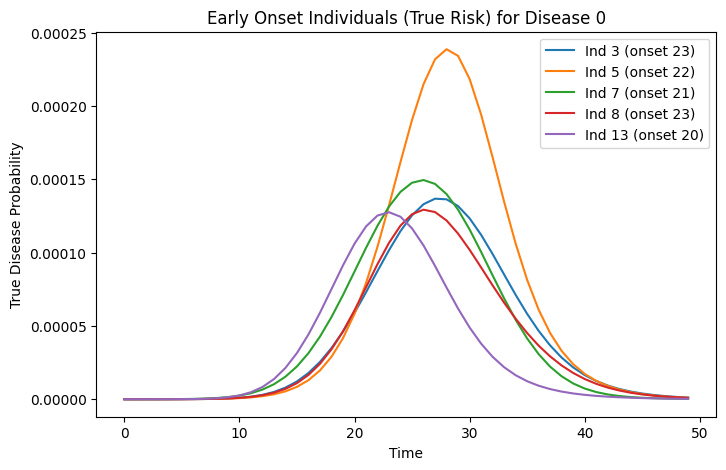

In [16]:
plt.figure(figsize=(8, 5))
for idx in early_inds[:5]:
    plt.plot(pi[valid][idx, d, :], label=f'Ind {idx} (onset {onset_times[idx]})')
plt.xlabel('Time')
plt.ylabel('True Disease Probability')
plt.title('Early Onset Individuals (True Risk) for Disease {}'.format(d))
plt.legend()
plt.savefig('early_onset_true.pdf')
plt.show()

In [17]:
# First generate synthetic data
from sim_with_warp import compute_smoothed_prevalence
np.random.seed(42)
data=data_warp
# Convert data to tensors for the model
Y_tensor = torch.tensor(data['Y'], dtype=torch.float32)
G_tensor = torch.tensor(data['G'], dtype=torch.float32)
E_tensor = torch.tensor(data['event_times'], dtype=torch.float32)
true_psi = torch.tensor(data['psi'], dtype=torch.float32)


# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(Y_tensor)  # Average over individuals



We'll fit warped data without Warping (using our trditional function) and see how things go ... 

In [18]:


np.random.seed(42)
torch.manual_seed(42)
model_no_warp = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True,
    disable_warping=True
)


/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 2 diseases
Cluster 1: 3 diseases
Cluster 2: 7 diseases
Cluster 3: 4 diseases
Cluster 4: 4 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 2
Base value (first 5): tensor([-3.8918, -3.8918, -3.8918, -3.8918, -3.8918])
Base value centered (first 5): tensor([0.3617, 0.3617, 0.3617, 0.3617, 0.3617])
Base value centered mean: -8.102417154987052e-07
Gamma init for k=0 (first 5): tensor([0.0844])

Calculating gamma for k=1:
Number of diseases in cluster: 3
Base value (first 5): tensor([-10.5076, -13.8155, -10.5076, -10.5076, -13.8155])
Base value centered (first 5): tensor([ 0.8988, -2.4091,  0.8988,  0.8988, -2.4091])
Base value centered mean: 4.7454832952098513e-07
Gamma init for k=1 (first 5): tensor([-0.7561])

Calculating gamma for k=2:
Number of diseases in cluster: 7
Base value (first 5): tensor([-8.1448, -8.1448, -9.5625, -9.5625, -9.5625])
Base value centered (first 5): tensor([ 0.7067,  0.7067, -0.7110, -0.7110, -0.7110])
Base value cent

In [19]:
from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
K=model_no_warp.K
# Store initial psi values
initial_psi = model_no_warp.psi.detach().clone()

import cProfile
import pstats
from pstats import SortKey
# Assuming your event times are in data_warp['E'] or similar
event_times = data['event_times'] 
# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model_no_warp.fit(event_times, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

pi (before clamp) min/max: 2.2019512879722924e-09 0.11295976489782333

Epoch 0
Loss: 36.3961
pi (before clamp) min/max: 2.4113815388915327e-09 0.12829133868217468

Monitoring signature responses:

Disease 2 (signature 4, LR=22.59):
  Theta for diagnosed: 0.182 ± 0.037
  Theta for others: 0.169
  Proportion difference: 0.013

Disease 6 (signature 1, LR=21.74):
  Theta for diagnosed: 0.319 ± 0.164
  Theta for others: 0.222
  Proportion difference: 0.098

Disease 16 (signature 2, LR=21.42):
  Theta for diagnosed: 0.171 ± 0.049
  Theta for others: 0.171
  Proportion difference: 0.000

Disease 1 (signature 2, LR=21.38):
  Theta for diagnosed: 0.194 ± 0.032
  Theta for others: 0.171
  Proportion difference: 0.023

Disease 14 (signature 4, LR=20.53):
  Theta for diagnosed: 0.181 ± 0.038
  Theta for others: 0.169
  Proportion difference: 0.012
pi (before clamp) min/max: 2.4113815388915327e-09 0.12829133868217468

Epoch 1
Loss: 174.3928
pi (before clamp) min/max: 2.6454798351949194e-09 0.139656

pi (before clamp) min/max: 8.092179371033126e-09 0.8006568551063538


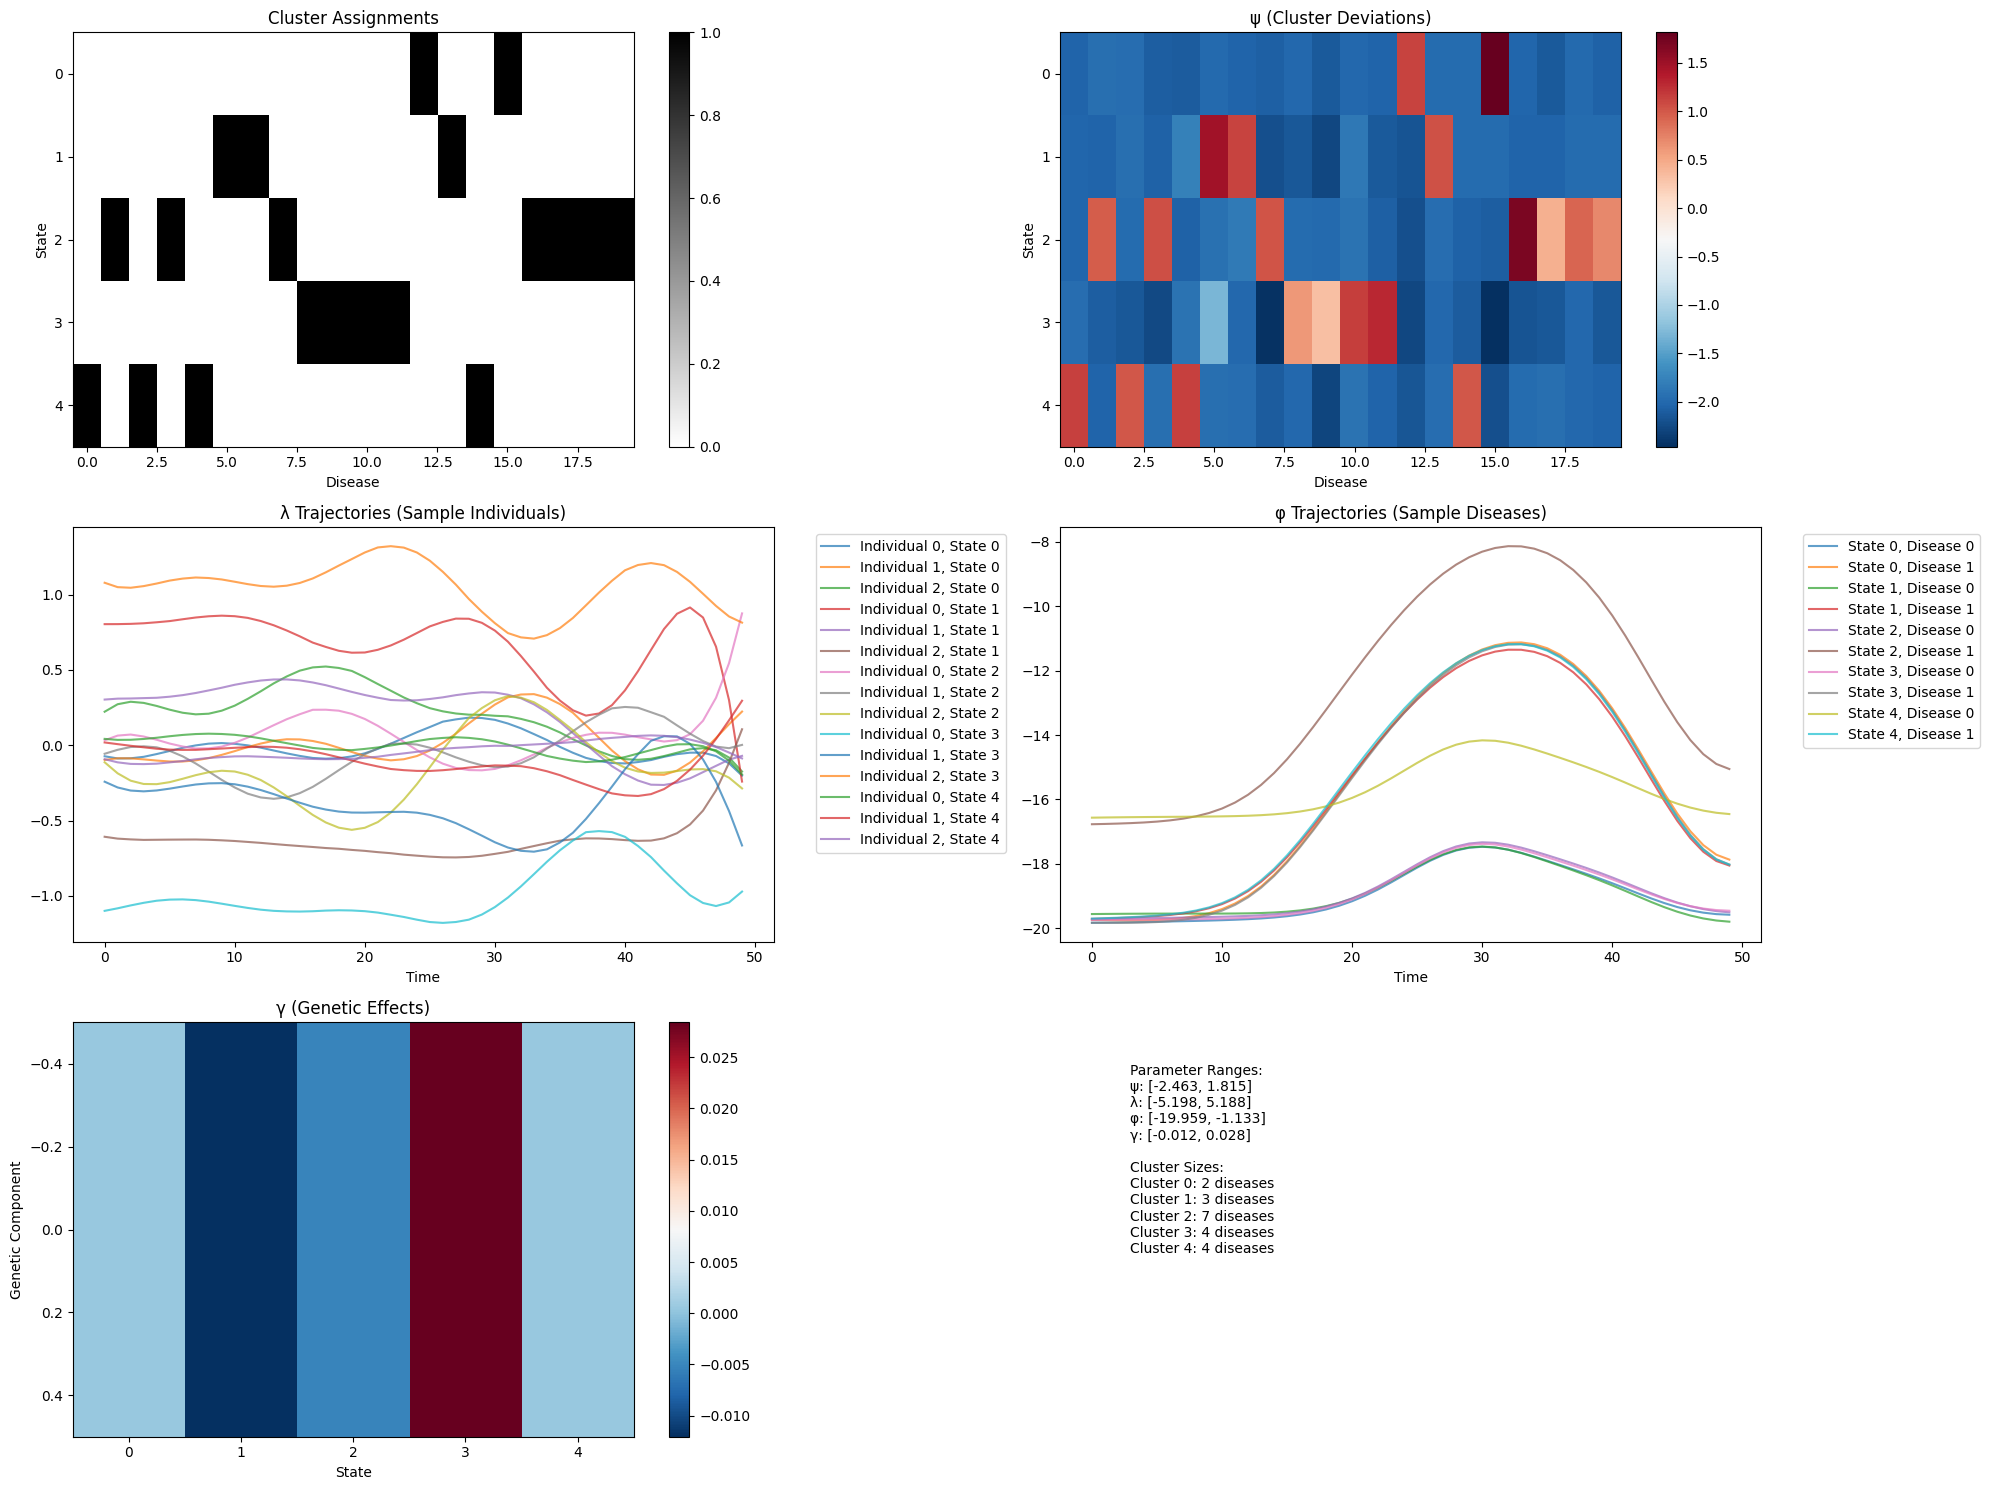

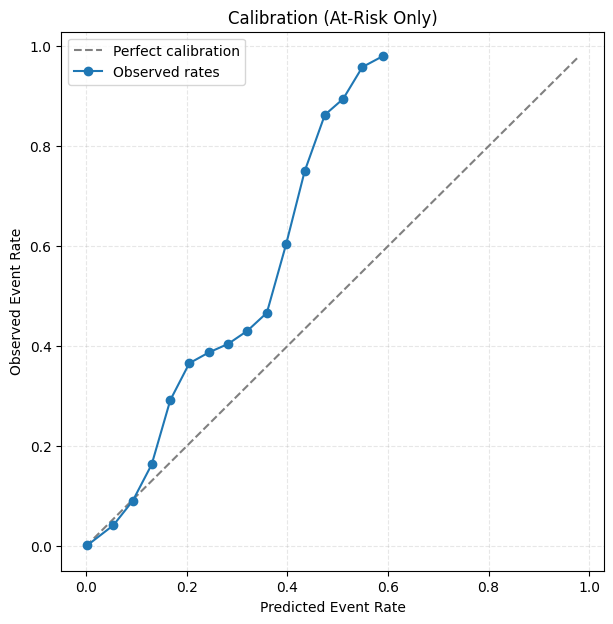

MSE: 5.38e-02
Mean Predicted: 9.30e-03
Mean Observed: 9.24e-03
N total: 8,807,934


([np.float32(0.002516555),
  np.float32(0.054489065),
  np.float32(0.09309517),
  np.float32(0.13066992),
  np.float32(0.16764641),
  np.float32(0.20543924),
  np.float32(0.2442741),
  np.float32(0.28280115),
  np.float32(0.32080147),
  np.float32(0.35950217),
  np.float32(0.39775607),
  np.float32(0.43464208),
  np.float32(0.47471398),
  np.float32(0.5111449),
  np.float32(0.549288),
  np.float32(0.58969045)],
 [np.float32(0.0016925193),
  np.float32(0.041953687),
  np.float32(0.09094321),
  np.float32(0.16357836),
  np.float32(0.29220408),
  np.float32(0.36599803),
  np.float32(0.38755655),
  np.float32(0.4048077),
  np.float32(0.430837),
  np.float32(0.4668588),
  np.float32(0.60393256),
  np.float32(0.75),
  np.float32(0.8627451),
  np.float32(0.8947368),
  np.float32(0.9583333),
  np.float32(0.98)],
 [np.int64(8092079),
  np.int64(382231),
  np.int64(178507),
  np.int64(94982),
  np.int64(38610),
  np.int64(12164),
  np.int64(4420),
  np.int64(2080),
  np.int64(1135),
  np.int64(6

In [55]:
# Get predictions
disease_names=model_no_warp.disease_names
pi, theta, phi_prob = model_no_warp.forward()
# If you have disease names, pass them in
#model_no_warp.visualize_clusters(disease_names=disease_names)
#model_no_warp.analyze_signature_responses()
model_no_warp.visualize_initialization()

# Calibration plot
from clust_huge_amp_w_warp import plot_calibration_at_risk
plot_calibration_at_risk(pi, model_no_warp.Y)

# (Optional

Note how we fit with the old model to test here 

In [37]:
from clust_huge_amp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
np.random.seed(42)
torch.manual_seed(42)
model_non_warp_old_model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True
)


## confirmed old model and new model without warping are the same 

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 4 diseases
Cluster 2: 3 diseases
Cluster 3: 2 diseases
Cluster 4: 2 diseases
Cluster 5: 3 diseases
Cluster 6: 1 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 5
Base value (first 5): tensor([-13.8155, -13.8155,  -9.8460, -11.8308, -13.8155])
Base value centered (first 5): tensor([-1.4858, -1.4858,  2.4837,  0.4990, -1.4858])
Base value centered mean: -1.4671326198367751e-06
Gamma init for k=0 (first 5): tensor([ 0.4905,  0.5386, -0.1792,  0.2446,  0.0048])

Calculating gamma for k=1:
Number of diseases in cluster: 4
Base value (first 5): tensor([ -8.8537,  -8.8537,  -8.8537,  -8.8537, -11.3346])
Base value centered (first 5): tensor([ 1.6257,  1.6257,  1.6257,  1.6257, -0.8552])
Base value centered mean: -3.684997693653713e-07
Gamma init for k=1 (first 5): tensor([-0.0648, -0.2441, -0.0293, -0.3815,  0.2329])

Calculating gamma for k=2:
Number of diseases in cluster: 3
Base value (first 5): tensor([-3.8918, -3.8918, 

WE showed they produce the same results.

## Now we fit with warping. 

In [56]:

from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
np.random.seed(42)
torch.manual_seed(42)
model_warp = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True,
    disable_warping=False
)   

initial_clusters =data_warp['clusters']
model_warp.clusters = initial_clusters

model_warp.initialize_params(true_psi=torch.tensor(data_warp['psi'], dtype=torch.float32))
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model_warp.clusters)
print(f"\nClusters match exactly: {clusters_match}")


/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 2 diseases
Cluster 1: 3 diseases
Cluster 2: 7 diseases
Cluster 3: 4 diseases
Cluster 4: 4 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 2
Base value (first 5): tensor([-3.8918, -3.8918, -3.8918, -3.8918, -3.8918])
Base value centered (first 5): tensor([0.3617, 0.3617, 0.3617, 0.3617, 0.3617])
Base value centered mean: -8.102417154987052e-07
Gamma init for k=0 (first 5): tensor([0.0844])

Calculating gamma for k=1:
Number of diseases in cluster: 3
Base value (first 5): tensor([-10.5076, -13.8155, -10.5076, -10.5076, -13.8155])
Base value centered (first 5): tensor([ 0.8988, -2.4091,  0.8988,  0.8988, -2.4091])
Base value centered mean: 4.7454832952098513e-07
Gamma init for k=1 (first 5): tensor([-0.7561])

Calculating gamma for k=2:
Number of diseases in cluster: 7
Base value (first 5): tensor([-8.1448, -8.1448, -9.5625, -9.5625, -9.5625])
Base value centered (first 5): tensor([ 0.7067,  0.7067, -0.7110, -0.7110, -0.7110])
Base value cent

In [ ]:
from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
K=model_warp.K
# Store initial psi values
initial_psi = model_warp.psi.detach().clone()

import cProfile
import pstats
from pstats import SortKey
# Assuming your event times are in data_warp['E'] or similar
event_times = data_warp['event_times'] 
# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model_warp.fit(event_times, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

rho stats: min = 0.6094086766242981 max = 1.6105931997299194 mean = 0.9884968996047974
t_warped stats: min = 0.0 max = 49.0 mean = 24.326005935668945
t_warped[0, 0, :10]: [0.         0.75708354 1.5911046  2.4568648  3.3439028  4.2471066
 5.163405   6.090739   7.027624   7.972944  ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.1757, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 7.796003287374731e-10 max = 0.17570900917053223
phi min/max: -20.972240447998047 -1.545694351196289
phi_prob_warped min/max: 7.796003287374731e-10 0.17570900917053223
theta min/max: 0.0005301372730173171 0.9847144484519958
pi (before clamp) min/max: 7.797334444781256e-10 0.17570903897285461
theta shape: torch.Size([10000, 5, 50])
phi_prob_warped shape: torch.Size([5, 20, 10000, 50])
kappa: Parameter containing:
tensor([1.], requires_grad=True)
rho grad norm: 0.12135003507137299

Epoch 0
Loss: 88.5691
rho stats: min = 0.6124104261398315 max = 1.6059197187423706 mean = 0.9895021915435791
t_warp

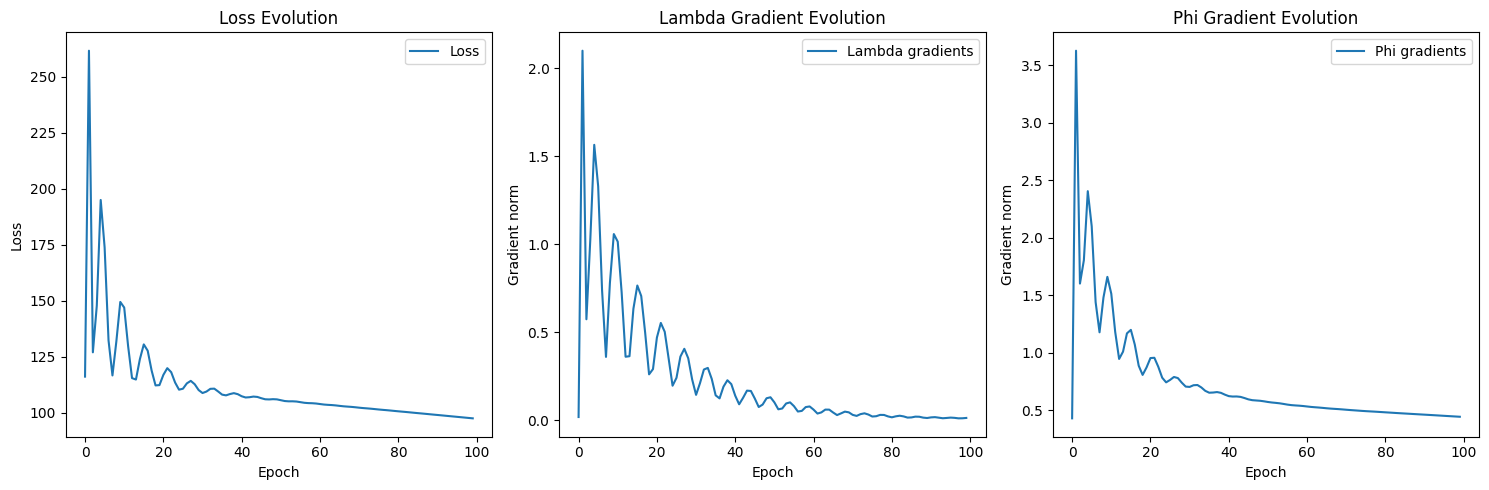

In [20]:
plot_training_evolution(history_new)

In [21]:
# Get predictions
pi, theta, phi_prob = model_warp.forward()

# (Optional) If you want the warped phi as well:
# pi, theta, phi_prob, phi_prob_warped = model_warp.forward(return_warped_phi=True)

rho stats: min = 0.5710885524749756 max = 2.0952394008636475 mean = 1.0758390426635742
t_warped stats: min = 0.0 max = 49.0 mean = 25.22798728942871
t_warped[0, 0, :10]: [ 0.         3.0555477  5.008676   6.6876845  8.2102585  9.62617
 10.962502  12.236089  13.458316  14.637349 ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.0575, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 7.07354952389494e-10 max = 0.0575079545378685
phi min/max: -21.069488525390625 -2.7966039180755615
phi_prob_warped min/max: 7.07354952389494e-10 0.0575079545378685
theta min/max: 0.015266290865838528 0.8640084862709045
pi (before clamp) min/max: 3.4337170884413126e-09 0.2788578271865845
theta shape: torch.Size([10000, 5, 50])
phi_prob_warped shape: torch.Size([5, 20, 10000, 50])
kappa: Parameter containing:
tensor([4.8543], requires_grad=True)


odict_keys(['kappa', 'gamma', 'lambda_', 'phi', 'psi', 'beta_warp_nn.weight', 'beta_warp_nn.bias'])

In [26]:
# If you have disease names, pass them in
# If you don't have real disease names, create dummy names:
model_warp = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/model_warp_warping.pt')
warp_data=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/warp_data.pt')


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_39784/1557615792.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_warp = torch.load('/Users/sarahurbut/Li

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sarahurbut/Library/CloudStorage/Dropbox/warp_data.pt'

In [ ]:

D = model_warp.D  # or data['Y'].shape[1]
disease_names = [f"Disease_{i}" for i in range(D)]

model_warp.visualize_clusters(disease_names=disease_names)
model_warp.analyze_signature_responses()

model_warp.visualize_initialization()

# Calibration plot
from clust_huge_amp_w_warp import plot_calibration_at_risk
plot_calibration_at_risk(pi, model_warp.Y,use_log_scale=True)

Fit without warping (with the new fitting function)

In [26]:
model_warp.psi.shape

torch.Size([5, 20])

In [29]:
np.mean(data_warp['Y'])

np.float64(0.0119669)

In [ ]:


# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new_no_warp = model_no_warp.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

In [48]:
torch.save(model_warp, 'model_warp.pt')

In [47]:
torch.save(model_no_warp, 'model_no_warp.pt')

rho stats: min = 0.24314624071121216 max = 4.247594833374023 mean = 1.1173560619354248
t_warped stats: min = 0.0 max = 49.0 mean = 25.21613883972168
t_warped[0, 0, :10]: [0.         0.416666   0.97394663 1.6004363  2.2765765  2.9922118
 3.740981   4.518477   5.3214426  6.1473613 ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.0636, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 8.70473249037218e-10 max = 0.0636490136384964
phi min/max: -20.861984252929688 -2.68860125541687
phi_prob_warped min/max: 8.70473249037218e-10 0.0636490136384964
theta min/max: 0.001628373865969479 0.8872731924057007
pi (before clamp) min/max: 5.3094511009987855e-09 0.22442182898521423
theta shape: torch.Size([10000, 7, 50])
phi_prob_warped shape: torch.Size([7, 20, 10000, 50])
kappa: Parameter containing:
tensor([4.5719], requires_grad=True)


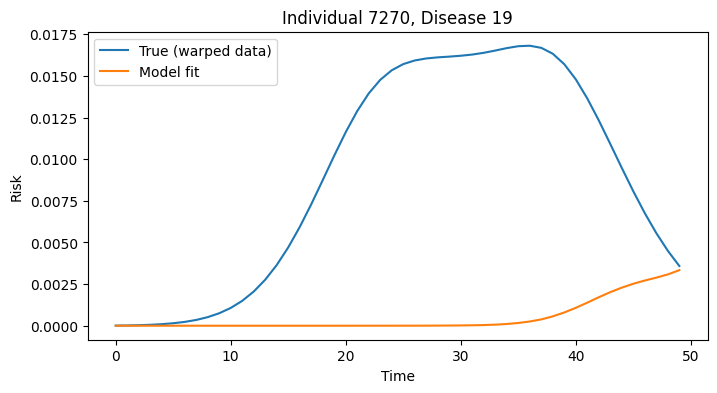

In [ ]:
pi_pred=model_warp.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]


import matplotlib.pyplot as plt
import numpy as np

# Pick a random individual and disease
i = np.random.randint(pi_pred.shape[0])
d = np.random.randint(pi_pred.shape[1])

plt.figure(figsize=(8, 4))
plt.plot(pi_true[i, d, :], label='True (warped data)')
plt.plot(pi_pred[i, d, :], label='Model fit')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title(f'Individual {i}, Disease {d}')
plt.legend()
plt.show()




In [52]:
eta = model_warp.beta_warp_nn(G_tensor)
inferred_rho = torch.exp(model_warp.beta_warp_nn(G_tensor)).detach().cpu().numpy()


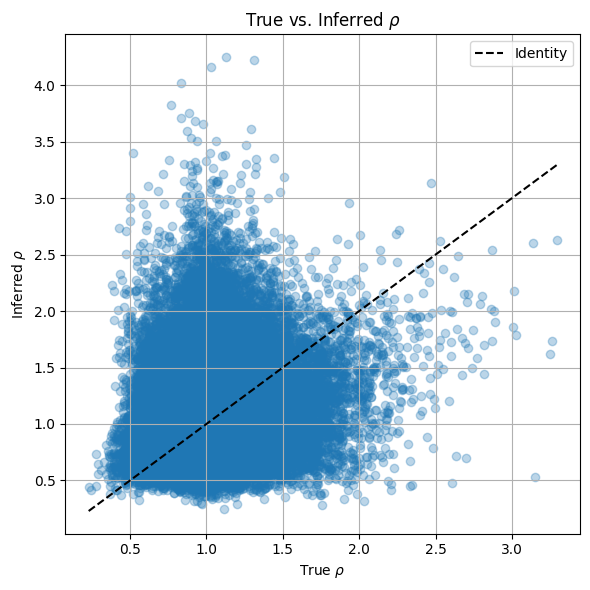

In [53]:
x = true_rho.flatten()
y = inferred_rho.flatten()

plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.3)
plt.xlabel("True $\\rho$")
plt.ylabel("Inferred $\\rho$")
plt.title("True vs. Inferred $\\rho$")
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'k--', label='Identity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

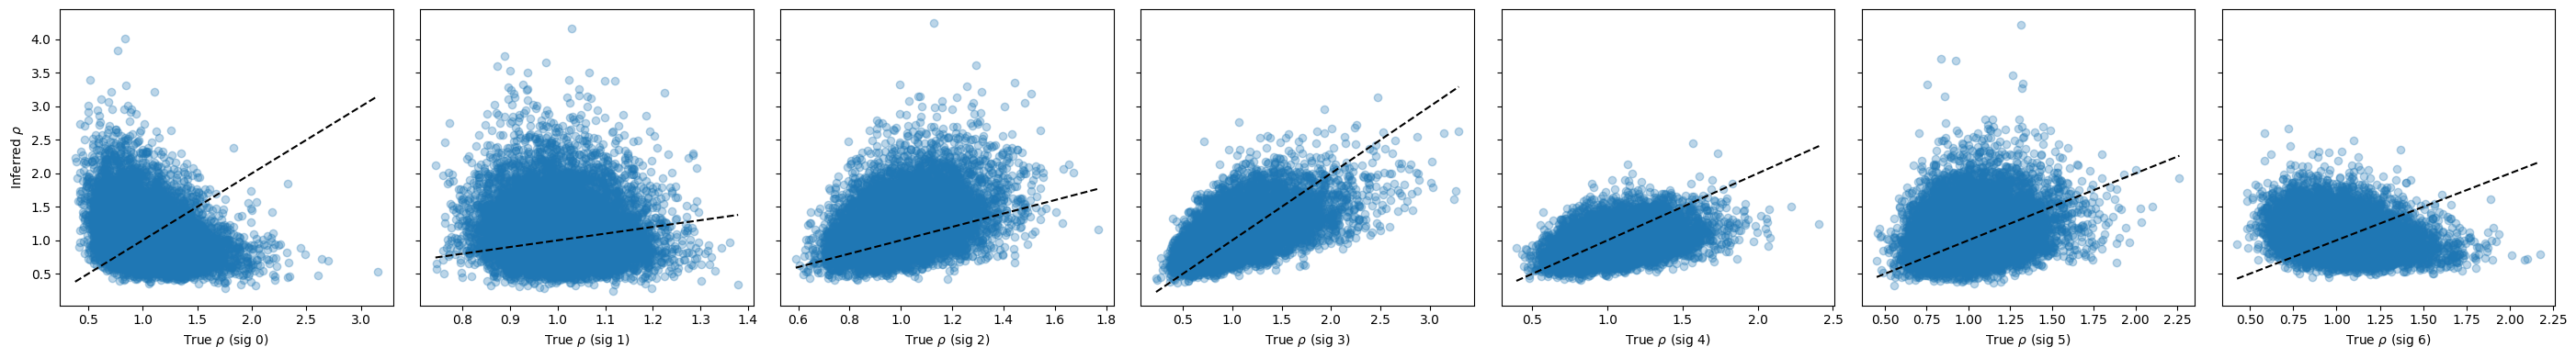

In [54]:
K = true_rho.shape[1]
fig, axs = plt.subplots(1, K, figsize=(4*K, 4), sharey=True)
for k in range(K):
    axs[k].scatter(true_rho[:, k], inferred_rho[:, k], alpha=0.3)
    axs[k].plot([true_rho[:, k].min(), true_rho[:, k].max()],
                [true_rho[:, k].min(), true_rho[:, k].max()], 'k--')
    axs[k].set_xlabel(f"True $\\rho$ (sig {k})")
    if k == 0:
        axs[k].set_ylabel("Inferred $\\rho$")
plt.tight_layout()
plt.show()

### start with the true beta_gs

In [55]:
import numpy as np
from scipy.optimize import linear_sum_assignment

# Convert to numpy arrays
learned = model_warp.beta_warp_nn.weight.data.cpu().numpy()
true = data_warp['beta_warp']

# If shapes are (signatures, features) for both, proceed. If not, transpose as needed.
if learned.shape != true.shape:
    true = true.T

# Compute cost matrix (negative correlation)
cost_matrix = np.zeros((learned.shape[0], true.shape[0]))
for i in range(learned.shape[0]):
    for j in range(true.shape[0]):
        cost_matrix[i, j] = -np.corrcoef(learned[i], true[j])[0, 1]

row_ind, col_ind = linear_sum_assignment(cost_matrix)
learned_matched = learned[row_ind]
true_matched = true[col_ind]

# Now compare
print("Correlation per signature:", [np.corrcoef(learned_matched[i], true_matched[i])[0,1] for i in range(learned.shape[0])])
print("MSE per signature:", [np.mean((learned_matched[i] - true_matched[i])**2) for i in range(learned.shape[0])])

Correlation per signature: [np.float64(0.1708291658193066), np.float64(0.5441346852210599), np.float64(0.8834380525370682), np.float64(0.8430002074716855), np.float64(0.45216700797505327), np.float64(0.11906122203473399), np.float64(0.5864962883152125)]
MSE per signature: [np.float64(0.04012824410186586), np.float64(0.017607726212342894), np.float64(0.005370524560513275), np.float64(0.0109838157448014), np.float64(0.009250091997159562), np.float64(0.022679572101311284), np.float64(0.010796370484424226)]


So the correlation doesn't look so good but the MSE isn't bad

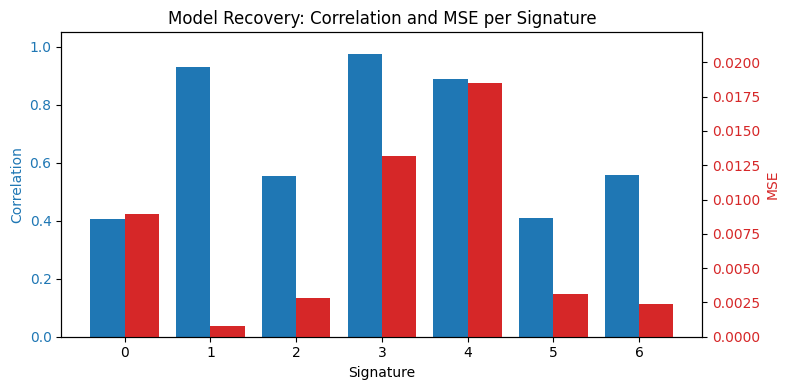

In [56]:
import matplotlib.pyplot as plt
import numpy as np

correlations = [0.4047, 0.9321, 0.5557, 0.9738, 0.8902, 0.4087, 0.5582]
mses = [0.00895, 0.00080, 0.00282, 0.01319, 0.01849, 0.00312, 0.00242]
signatures = np.arange(len(correlations))

fig, ax1 = plt.subplots(figsize=(8,4))

color = 'tab:blue'
ax1.set_xlabel('Signature')
ax1.set_ylabel('Correlation', color=color)
ax1.bar(signatures-0.2, correlations, width=0.4, color=color, label='Correlation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1.05)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MSE', color=color)
ax2.bar(signatures+0.2, mses, width=0.4, color=color, label='MSE')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, max(mses)*1.2)

plt.title('Model Recovery: Correlation and MSE per Signature')
ax1.set_xticks(signatures)
ax1.set_xticklabels([str(i) for i in signatures])
fig.tight_layout()
plt.show()

Some intuition on how warping works

In [58]:
# Time grid
T=model_warp.T
time_points = torch.arange(T, dtype=torch.float32)  # [0, 1, ..., T-1]
print("\ntime_points:", time_points)



time_points: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49.])


In [59]:

# Normalize time grid
T_minus_1 = T - 1
t_norm = time_points / T_minus_1  # Shape: [T]
print("\nt_norm:", t_norm)



t_norm: tensor([0.0000, 0.0204, 0.0408, 0.0612, 0.0816, 0.1020, 0.1224, 0.1429, 0.1633,
        0.1837, 0.2041, 0.2245, 0.2449, 0.2653, 0.2857, 0.3061, 0.3265, 0.3469,
        0.3673, 0.3878, 0.4082, 0.4286, 0.4490, 0.4694, 0.4898, 0.5102, 0.5306,
        0.5510, 0.5714, 0.5918, 0.6122, 0.6327, 0.6531, 0.6735, 0.6939, 0.7143,
        0.7347, 0.7551, 0.7755, 0.7959, 0.8163, 0.8367, 0.8571, 0.8776, 0.8980,
        0.9184, 0.9388, 0.9592, 0.9796, 1.0000])


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Example dimensions
N = 2          # Number of individuals
K_total = 3     # Number of signatures
T = 10          # Number of time points

# Example warping parameters (rho)
rho = torch.tensor([[1.0, 2.0, 0.5],    # Individual 0: 3 signatures
                    [1.5, 1.0, 2.0]])  # Individual 1: 3 signatures
# Shape: [N, K_total]

print("rho shape:", rho.shape)
print("rho:\n", rho)
# Add a new axis for time
rho_exp = rho.unsqueeze(-1)  # Shape: [N, K_total, 1]
print("\nrho.unsqueeze(-1) shape:", rho_exp.shape)
print("rho.unsqueeze(-1):\n", rho_exp)


rho shape: torch.Size([2, 3])
rho:
 tensor([[1.0000, 2.0000, 0.5000],
        [1.5000, 1.0000, 2.0000]])

rho.unsqueeze(-1) shape: torch.Size([2, 3, 1])
rho.unsqueeze(-1):
 tensor([[[1.0000],
         [2.0000],
         [0.5000]],

        [[1.5000],
         [1.0000],
         [2.0000]]])



time_points: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

t_norm: tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

t_warped shape: torch.Size([2, 3, 10])
t_warped[0, 0, :]: tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
t_warped[1, 2, :]: tensor([0.0000, 3.0000, 4.2426, 5.1962, 6.0000, 6.7082, 7.3485, 7.9373, 8.4853,
        9.0000])


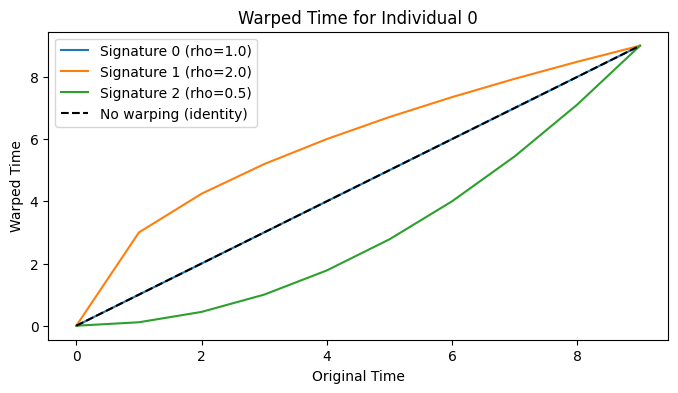

In [76]:

# Compute warped time
# Normalize time grid
# Time grid
time_points = torch.arange(T, dtype=torch.float32)  # [0, 1, ..., T-1]
print("\ntime_points:", time_points)
# Normalize time grid
T_minus_1 = T - 1
t_norm = time_points / T_minus_1  # Shape: [T]
print("\nt_norm:", t_norm)

t_warped = (t_norm ** (1.0 / rho_exp)) * T_minus_1  # Shape: [N, K_total, T]
print("\nt_warped shape:", t_warped.shape)
print("t_warped[0, 0, :]:", t_warped[0, 0, :])  # Individual 0, signature 0
print("t_warped[1, 2, :]:", t_warped[1, 2, :])  # Individual 1, signature 2

# Visualize for one individual and all signatures
plt.figure(figsize=(8, 4))
for k in range(K_total):
    plt.plot(t_norm.numpy() * T_minus_1, t_warped[0, k, :].numpy(), label=f'Signature {k} (rho={rho[0, k].item()})')
plt.plot(t_norm.numpy() * T_minus_1, t_norm.numpy() * T_minus_1, 'k--', label='No warping (identity)')
plt.xlabel('Original Time')
plt.ylabel('Warped Time')
plt.title('Warped Time for Individual 0')
plt.legend()
plt.savefig('warp_true.pdf')
plt.show()

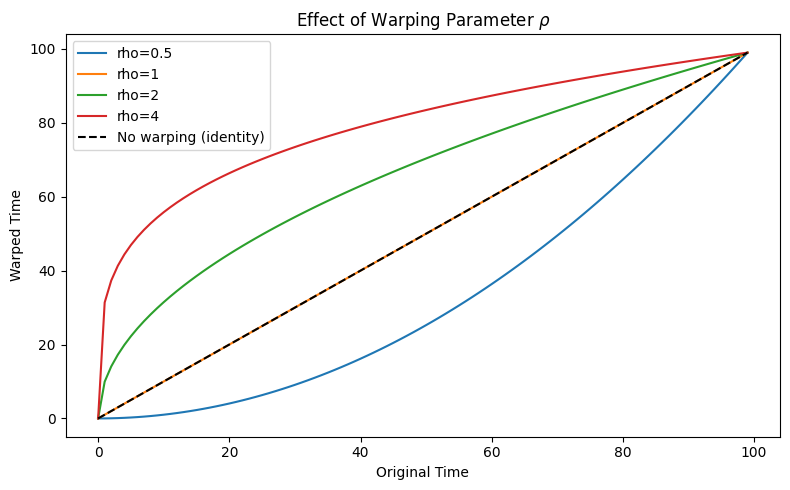

In [1]:
import numpy as np
import matplotlib.pyplot as plt

T = 100
t = np.arange(T)
t_norm = t / (T - 1)

rho_values = [0.5, 1, 2, 4]
plt.figure(figsize=(8, 5))

for rho in rho_values:
    t_warped = (t_norm ** (1.0 / rho)) * (T - 1)
    plt.plot(t, t_warped, label=f'rho={rho}')

plt.plot(t, t, 'k--', label='No warping (identity)')
plt.xlabel('Original Time')
plt.ylabel('Warped Time')
plt.title('Effect of Warping Parameter $\\rho$')
plt.legend()
plt.tight_layout()
plt.show()

In [78]:
import numpy as np

corr = np.corrcoef(true_rho.flatten(), inferred_rho.flatten())[0, 1]
print(f'Correlation between true and inferred $\\rho$: {corr:.3f}')

Correlation between true and inferred $\rho$: 0.122


rho stats: min = 0.24314624071121216 max = 4.247594833374023 mean = 1.1173560619354248
t_warped stats: min = 0.0 max = 49.0 mean = 25.21613883972168
t_warped[0, 0, :10]: [0.         0.416666   0.97394663 1.6004363  2.2765765  2.9922118
 3.740981   4.518477   5.3214426  6.1473613 ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.0636, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 8.70473249037218e-10 max = 0.0636490136384964
phi min/max: -20.861984252929688 -2.68860125541687
phi_prob_warped min/max: 8.70473249037218e-10 0.0636490136384964
theta min/max: 0.001628373865969479 0.8872731924057007
pi (before clamp) min/max: 5.3094511009987855e-09 0.22442182898521423
theta shape: torch.Size([10000, 7, 50])
phi_prob_warped shape: torch.Size([7, 20, 10000, 50])
kappa: Parameter containing:
tensor([4.5719], requires_grad=True)


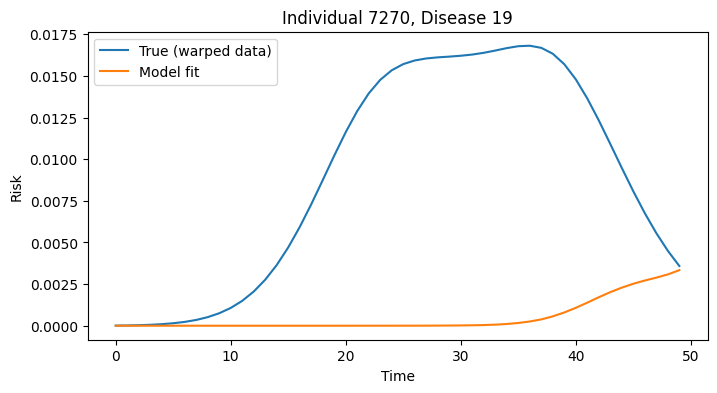

In [79]:
pi_pred=model_warp.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]


import matplotlib.pyplot as plt
import numpy as np

# Pick a random individual and disease
i = np.random.randint(pi_pred.shape[0])
d = np.random.randint(pi_pred.shape[1])

plt.figure(figsize=(8, 4))
plt.plot(pi_true[i, d, :], label='True (warped data)')
plt.plot(pi_pred[i, d, :], label='Model fit')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title(f'Individual {i}, Disease {d}')
plt.legend()
plt.show()




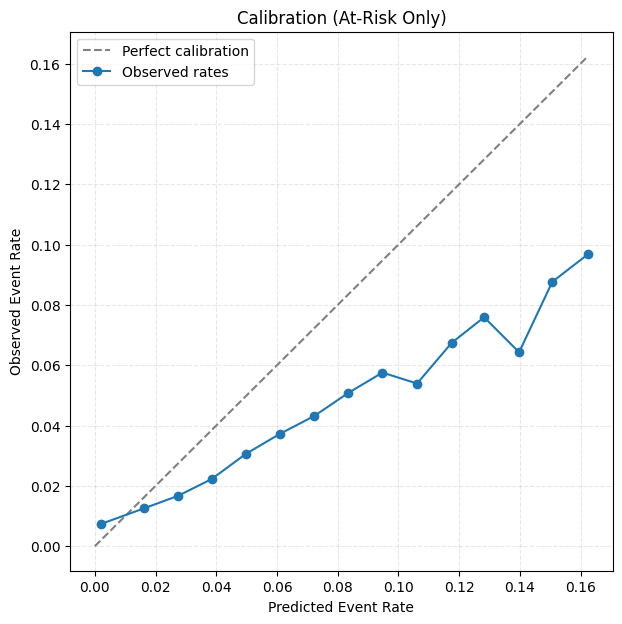

MSE: 1.77e-03
Mean Predicted: 8.85e-03
Mean Observed: 1.02e-02
N total: 8,403,243


([np.float32(0.0018892653),
  np.float32(0.016303083),
  np.float32(0.027494192),
  np.float32(0.03852577),
  np.float32(0.049718887),
  np.float32(0.06096525),
  np.float32(0.07230002),
  np.float32(0.08353829),
  np.float32(0.09473688),
  np.float32(0.106121734),
  np.float32(0.11755293),
  np.float32(0.12820484),
  np.float32(0.13972928),
  np.float32(0.15066426),
  np.float32(0.16241519)],
 [np.float32(0.0073341927),
  np.float32(0.0125837885),
  np.float32(0.01673713),
  np.float32(0.022292724),
  np.float32(0.030597249),
  np.float32(0.03725006),
  np.float32(0.043186504),
  np.float32(0.05085696),
  np.float32(0.057557475),
  np.float32(0.05392157),
  np.float32(0.06744186),
  np.float32(0.07589286),
  np.float32(0.06428572),
  np.float32(0.087649405),
  np.float32(0.09677419)],
 [np.int64(6065153),
  np.int64(1145442),
  np.int64(625854),
  np.int64(318983),
  np.int64(136777),
  np.int64(59114),
  np.int64(26675),
  np.int64(12486),
  np.int64(6133),
  np.int64(3060),
  np.int

In [80]:
plot_calibration_at_risk(pi_pred, Y_tensor, n_bins=20, min_bin_count=50, use_log_scale=False)


NOw do it without warp

pi (before clamp) min/max: 1.1630117313643495e-08 0.7483147382736206


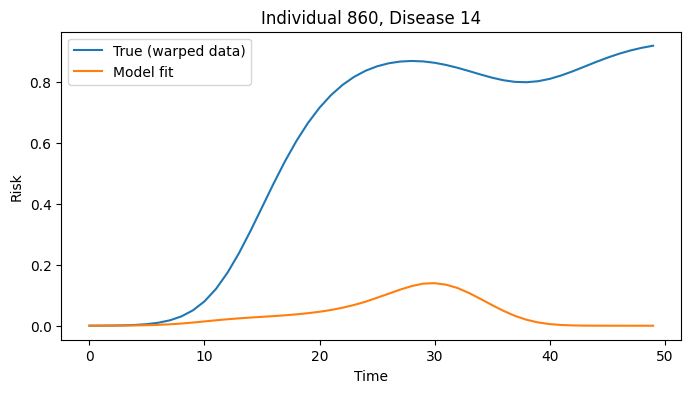

In [81]:
pi_pred=model_no_warp.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]


import matplotlib.pyplot as plt
import numpy as np

# Pick a random individual and disease
i = np.random.randint(pi_pred.shape[0])
d = np.random.randint(pi_pred.shape[1])

plt.figure(figsize=(8, 4))
plt.plot(pi_true[i, d, :], label='True (warped data)')
plt.plot(pi_pred[i, d, :], label='Model fit')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title(f'Individual {i}, Disease {d}')
plt.legend()
plt.show()




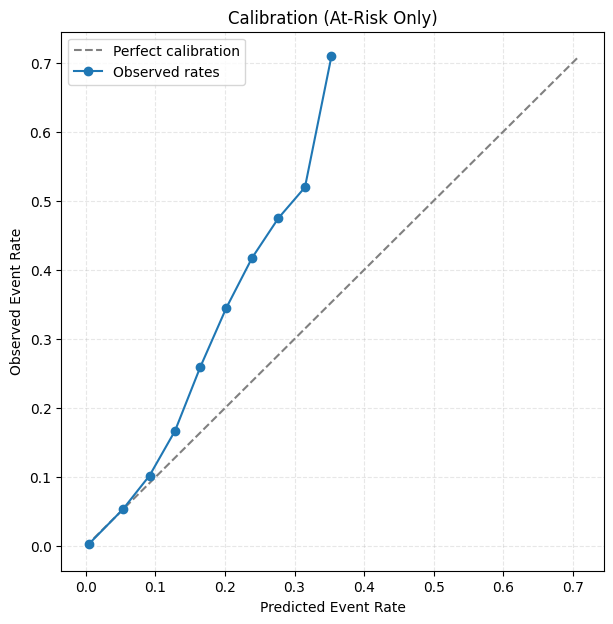

MSE: 2.71e-02
Mean Predicted: 1.00e-02
Mean Observed: 1.02e-02
N total: 8,403,243


([np.float32(0.0041191597),
  np.float32(0.052940387),
  np.float32(0.09158028),
  np.float32(0.1281363),
  np.float32(0.16458069),
  np.float32(0.20174225),
  np.float32(0.23903015),
  np.float32(0.27678397),
  np.float32(0.31497705),
  np.float32(0.3530983)],
 [np.float32(0.0030985656),
  np.float32(0.053175215),
  np.float32(0.10236999),
  np.float32(0.16707389),
  np.float32(0.25965118),
  np.float32(0.3446699),
  np.float32(0.4175577),
  np.float32(0.4748954),
  np.float32(0.51955307),
  np.float32(0.7093023)],
 [np.int64(7740033),
  np.int64(378447),
  np.int64(166963),
  np.int64(81036),
  np.int64(27121),
  np.int64(6998),
  np.int64(1777),
  np.int64(478),
  np.int64(179),
  np.int64(86)])

In [82]:
plot_calibration_at_risk(pi_pred, Y_tensor, n_bins=20, min_bin_count=50, use_log_scale=False)

# Staged training
Here, we fit fixing rho, and then we run fixing phi, lambda and fit the warping 

In [ ]:

from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
np.random.seed(42)
torch.manual_seed(42)
model_staged = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True,
    disable_warping=True
)




import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model_staged.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)
from clust_huge_amp_w_warp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest
K=5
# Store initial psi values




In [86]:
pi_pred=model_staged.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]

pi (before clamp) min/max: 1.1630117313643495e-08 0.7483147382736206


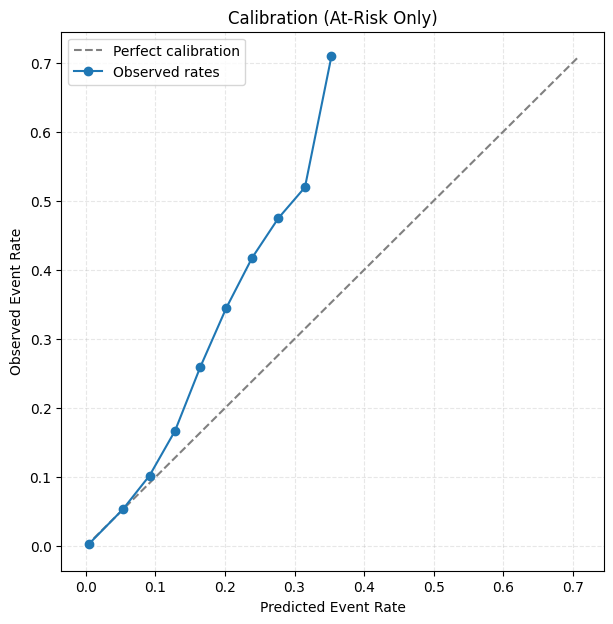

MSE: 2.71e-02
Mean Predicted: 1.00e-02
Mean Observed: 1.02e-02
N total: 8,403,243


([np.float32(0.0041191597),
  np.float32(0.052940387),
  np.float32(0.09158028),
  np.float32(0.1281363),
  np.float32(0.16458069),
  np.float32(0.20174225),
  np.float32(0.23903015),
  np.float32(0.27678397),
  np.float32(0.31497705),
  np.float32(0.3530983)],
 [np.float32(0.0030985656),
  np.float32(0.053175215),
  np.float32(0.10236999),
  np.float32(0.16707389),
  np.float32(0.25965118),
  np.float32(0.3446699),
  np.float32(0.4175577),
  np.float32(0.4748954),
  np.float32(0.51955307),
  np.float32(0.7093023)],
 [np.int64(7740033),
  np.int64(378447),
  np.int64(166963),
  np.int64(81036),
  np.int64(27121),
  np.int64(6998),
  np.int64(1777),
  np.int64(478),
  np.int64(179),
  np.int64(86)])

In [88]:
plot_calibration_at_risk(pi_pred, Y_tensor, n_bins=20, min_bin_count=50, use_log_scale=False)


pi (before clamp) min/max: 1.1630117313643495e-08 0.7483147382736206


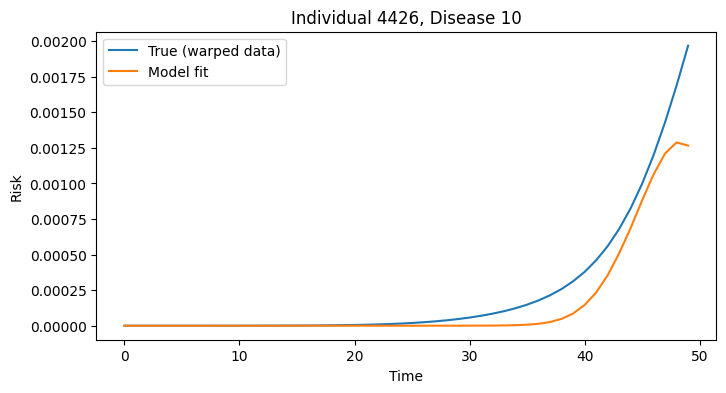

In [93]:
pi_pred=model_staged.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]


import matplotlib.pyplot as plt
import numpy as np

# Pick a random individual and disease
i = np.random.randint(pi_pred.shape[0])
d = np.random.randint(pi_pred.shape[1])

plt.figure(figsize=(8, 4))
plt.plot(pi_true[i, d, :], label='True (warped data)')
plt.plot(pi_pred[i, d, :], label='Model fit')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title(f'Individual {i}, Disease {d}')
plt.legend()
plt.show()

Now fix the phi and lambda parameters and fit with warping


In [ ]:


model_staged.lambda_.requires_grad = False
model_staged.phi.requires_grad = False
model_staged.disable_warping = False
profiler = cProfile.Profile()
profiler.enable()
history_new = model_staged.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

rho stats: min = 0.24198713898658752 max = 4.356817722320557 mean = 1.1299943923950195
t_warped stats: min = 0.0 max = 49.0 mean = 25.284400939941406
t_warped[0, 0, :10]: [0.         0.47446284 1.0836817  1.7568212  2.4751487  3.229065
 4.0126114  4.8216887  5.6532845  6.505083  ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.2358, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 2.1244965786593184e-09 max = 0.2358204424381256
phi min/max: -19.9697322845459 -1.1757317781448364
phi_prob_warped min/max: 2.1244965786593184e-09 0.2358204424381256
theta min/max: 0.004263462498784065 0.8795561194419861
pi (before clamp) min/max: 7.505099652860281e-09 0.45926111936569214
theta shape: torch.Size([10000, 7, 50])
phi_prob_warped shape: torch.Size([7, 20, 10000, 50])
kappa: Parameter containing:
tensor([2.5427], requires_grad=True)


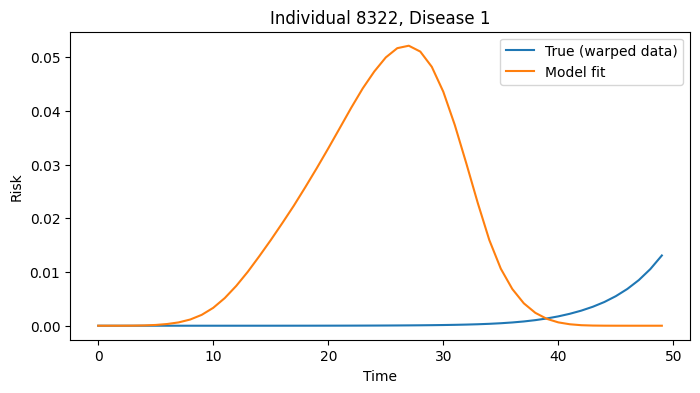

In [95]:
pi_pred=model_staged.forward()[0].detach().cpu()
pi_true = data_warp['pi']  # [N, D, T]


import matplotlib.pyplot as plt
import numpy as np

# Pick a random individual and disease
i = np.random.randint(pi_pred.shape[0])
d = np.random.randint(pi_pred.shape[1])

plt.figure(figsize=(8, 4))
plt.plot(pi_true[i, d, :], label='True (warped data)')
plt.plot(pi_pred[i, d, :], label='Model fit')
plt.xlabel('Time')
plt.ylabel('Risk')
plt.title(f'Individual {i}, Disease {d}')
plt.legend()
plt.show()

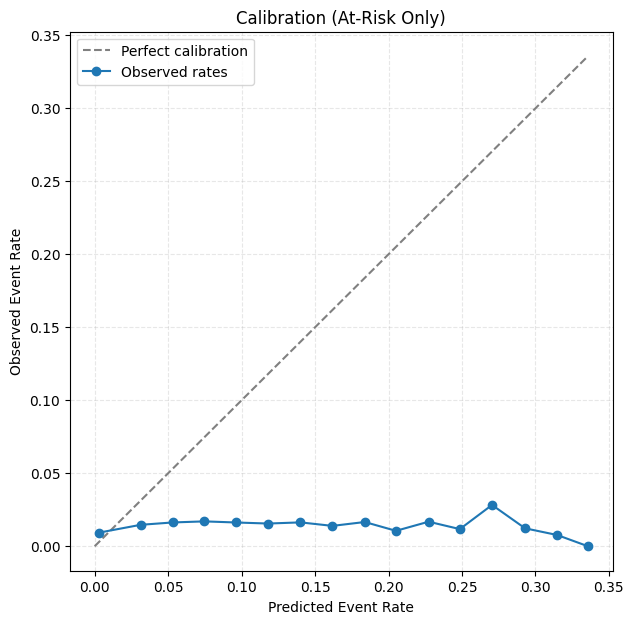

MSE: 3.56e-02
Mean Predicted: 9.73e-03
Mean Observed: 1.02e-02
N total: 8,403,243


([np.float32(0.002916347),
  np.float32(0.03130801),
  np.float32(0.05317941),
  np.float32(0.07469181),
  np.float32(0.09629083),
  np.float32(0.11808502),
  np.float32(0.14007707),
  np.float32(0.1618089),
  np.float32(0.18383265),
  np.float32(0.20506859),
  np.float32(0.22729446),
  np.float32(0.24854441),
  np.float32(0.27044952),
  np.float32(0.2929462),
  np.float32(0.3147609),
  np.float32(0.33568373)],
 [np.float32(0.009304738),
  np.float32(0.01467206),
  np.float32(0.016288247),
  np.float32(0.017019741),
  np.float32(0.016251419),
  np.float32(0.015540233),
  np.float32(0.016331747),
  np.float32(0.013938199),
  np.float32(0.016581632),
  np.float32(0.010546501),
  np.float32(0.016799293),
  np.float32(0.0117252935),
  np.float32(0.028268551),
  np.float32(0.012269938),
  np.float32(0.0076923077),
  np.float32(0.0)],
 [np.int64(7241580),
  np.int64(574357),
  np.int64(309180),
  np.int64(152470),
  np.int64(66948),
  np.int64(28571),
  np.int64(14083),
  np.int64(7605),
  n

In [97]:
plot_calibration_at_risk(pi_pred, Y_tensor, n_bins=20, min_bin_count=50, use_log_scale=False)


In [98]:
torch.save(model_staged, 'model_staged.pt')